# Image classifier

In [1]:
import keras
import tensorflow as tf
import numpy as np

# Load the data

In [37]:
# get the data from the keras datasets
(X_train_full, y_train_full), (X_test_full, y_test_full) = keras.datasets.cifar10.load_data()

| Label | Class          |
|-------|----------------|
| 0     | airplane ✈️    |
| 1     | automobile 🚗  |
| 2     | bird 🐦        |
| 3     | cat 🐱         |
| 4     | deer 🦌        |
| 5     | dog 🐶         |
| 6     | frog 🐸        |
| 7     | horse 🐴       |
| 8     | ship 🚢        |
| 9     | truck 🚚       |

We are going to work classifying airplanes and ships.

In [38]:
# flatten the arrays to work
y_train_full = y_train_full.flatten()
y_test_full = y_test_full.flatten()

Get the indexes of the images we are going to work with

In [39]:
# get the indices of the elements that are plains or ships
train_indexes = np.where((y_train_full == 0) | (y_train_full == 8))[0]
test_indexes = np.where((y_test_full == 0) | (y_test_full == 8))[0]

Now just stay with the revelant images in train and test

In [40]:
# get the images
X_train = X_train_full[train_indexes]
X_test = X_test_full[test_indexes]

y_train = y_train_full[train_indexes]
y_test = y_test_full[test_indexes]

# Visualize the data

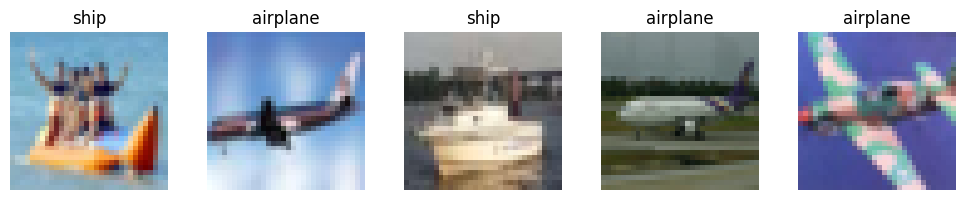

In [41]:
import matplotlib.pyplot as plt


class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Mostrar las primeras 5 imágenes de gatos/perros
plt.figure(figsize=(10, 2))

for i, idx in enumerate(train_indexes[:5]):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_train[idx])
    label = class_names[y_train[idx]]
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(tf.keras.backend.get_value(labels[i]))
    plt.axis("off")

Let's verify what is the content of train_ds

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

The image_batch is a tensor of the shape (12, 120, 120, 3). This is a batch of 16 with shape 160x160x3 (the last dimension refers to color channels RGB and the images are 120x120 because that is the value we set on the **image_dataset_from_directory** function). The label_batch is a tensor of the shape (12,), these are corresponding **labels** to the 12 images.

# Configure the dataset for performance

We are going to use buffered prefetching, so we can yield data from disk without having I/O become blocking. The two important methods we should use when loading data are:

- **Dataset.cache** keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- **Dataset.prefetch** overlaps data preprocessing and model execution while training.
Interested readers can learn more about both methods.

In [ ]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Standardize the data

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Now we standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [ ]:
# normalization_layer = tf.keras.layers.Rescaling(1./255)

Now there are two ways to use this layer. We can apply it to the dataset by calling Dataset.map:

In [ ]:
# normalize all the data
# normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

# let's print the first image to see the normalization
# image_batch, labels_batch = next(iter(normalized_train_ds))
# first_image = image_batch[0]
# print('Min and Max values:', np.min(first_image), '-', np.max(first_image))

Or we can include this layer in the model, the same can be done with the Resizing using the **tf.keras.layers.Resizing** layer (we are going to do this option).

# Now let's create the model (CNN)

This time we are following the models given to use:

In [ ]:
from keras import Sequential, layers, regularizers


model = Sequential([
    # set this Input layer to delete the warning
    layers.Input(shape=(img_height, img_width, 3)),
    # here is where the rescaling layer can be
    layers.Rescaling(1./255),

    # rest of the layers
    layers.Conv2D(filters = 32, kernel_size = (3,3), padding = "same", activation = "relu", kernel_regularizer=regularizers.L2(0.001)),
    layers.Conv2D(filters = 32,kernel_size = (3,3),padding = "same", activation = "relu", kernel_regularizer=regularizers.L2(0.001)),
    layers.MaxPool2D(pool_size = (2,2),strides = (2,2)),
    # dropout layer
    layers.Dropout(0.5),

    layers.Conv2D(filters = 64, kernel_size = (3,3), padding = "same", activation = "relu", kernel_regularizer=regularizers.L2(0.001)),
    layers.Conv2D(filters = 64, kernel_size = (3,3), padding = "same", activation = "relu", kernel_regularizer=regularizers.L2(0.001)),
    layers.MaxPool2D(pool_size = (2,2),strides = (2,2)),
    # dropout layer
    layers.Dropout(0.5),

    layers.Flatten(),
    layers.Dense(units = 512,activation = "relu", kernel_regularizer=regularizers.L2(0.001)),
    # dropout layer
    layers.Dropout(0.5),
    layers.Dense(units = 512,activation = "relu", kernel_regularizer=regularizers.L2(0.001)),
    # dropout layer
    layers.Dropout(0.5),

    # output layer
    layers.Dense(units = 2, activation = "softmax"),
])

# Compile the model

This time we are going to use the **tf.keras.optimizers.Adam** optimizer and **tf.keras.losses.SparseCategoricalCrossentropy** loss function.

In [ ]:
model.compile(
    optimizer='adam',
    loss=['categorical_crossentropy'], # use this loss function based on the load labels that we used
    metrics=['accuracy'] # we can use accuracy because the training data is balanced
)

# Model summary

We can see all the layers of the network using the Keras **Model.summary** method:

In [ ]:
model.summary()

# Train the model

In [ ]:
# filter warnings to not see them during training (this is not working)
import tensorflow as tf

tf.get_logger().setLevel('ERROR')

Early stopping conf

In [ ]:
from keras.src.callbacks import EarlyStopping


early_stopping = EarlyStopping(
    monitor='val_loss',         # metric to verify
    patience=25,                 # number of epochs without change to stop
    restore_best_weights=True
)

Learning rate scheduler

In [ ]:
from keras.src.callbacks import LearningRateScheduler


def scheduler(epoch, lr):
    """
    Scheduler that reduces the learning rate by 10.
    """
    if epoch < 10:
        return lr
    else:
        return lr * 0.1

lr_scheduler = LearningRateScheduler(scheduler)

Fitting of the model

In [ ]:
# epoch to train
epochs = 100

# train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping],
    verbose=0
)

# Visualize training results

In [ ]:
# get the values to graph
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['val_accuracy']))

# create the graphs
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Analysis

# Save the model

In [ ]:
save_dir = os.path.abspath('/mnt/f/Courses/4GeeksAcademy/DataScience/DeliverableExercises/alejandroNovellino-image-classifier-project/models')

model.save(f'{save_dir}/in_data_simpler_base_model.keras')

Now clear the memory to continue working

In [ ]:
from keras.src.backend.common.global_state import clear_session

clear_session(
    free_memory=True
)